# Capstone Project: Deep RL Trading Agent

## Introduction

Here is the structure of the project Python source code: 

- `task.py`: the environment definition in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `buyandholdagent.py`: Benchmark agent.
    - `deeprlagent.py`: the deep rl trading agent.
- `market.py`: This file contains the interface to the stock market data.
- `data/`: stock prices.
- `resources/`: additional files.

## Data Loading and Data Cleansing of finance data
The data set is constructed from the raw data files.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from market import Market
from task import Task



# loading the stock prices
# all trade data is coming from XETRA

df_usinterest =  pd.read_csv('data/FRB_H15.csv', header=5, names=['day','US_rate'], skiprows=0, parse_dates=[0],\
                          infer_datetime_format=True)

df_sp500_prices = pd.read_csv('data/Investing_622391_historic_data.csv', header=0,\
                           names=['day','closing', 'opening', 'high', 'low', 'vol', 'change'],\
                           skiprows=0, parse_dates=[0], infer_datetime_format=True, decimal=',')

df_eurostoxx600_prices = pd.read_csv('data/Investing_DBX1A7_historic_data.csv', header=0,\
                           names=['day','closing', 'opening', 'high', 'low', 'vol', 'change'],\
                           skiprows=0, parse_dates=[0], infer_datetime_format=True, decimal=',')

df_msciworld_prices = pd.read_csv('data/Investing_ETF110_historic_data.csv', header=0,\
                           names=['day','closing', 'opening', 'high', 'low', 'vol', 'change'],\
                           skiprows=0, parse_dates=[0], infer_datetime_format=True, decimal='.')

# convert vol column to float dtype
#1. remove K, M, -
#2. replace , with .
#3. parse as float
#4. multiply by 1000, 1000000
def vol2float(x):
    if (x.find('-')!=-1):
        return float(0.0)
    
    if (x.find('K')!=-1):
        return float(x.replace('K','').replace(',','.'))*1000.00
    
    if (x.find('M')!=-1):
        return float(x.replace('M','').replace(',','.'))*1000000.00
    
    return float('nan')

df_sp500_prices['SP500_volno'] = df_sp500_prices['vol'].apply(vol2float)
df_eurostoxx600_prices['ESTOXX_volno'] = df_eurostoxx600_prices['vol'].apply(vol2float)
df_msciworld_prices['MSCI_volno'] = df_msciworld_prices['vol'].apply(vol2float)

# remove records without closing price
df_sp500_prices = df_sp500_prices.dropna(subset=['closing'])
df_eurostoxx600_prices = df_eurostoxx600_prices.dropna(subset=['closing'])
df_msciworld_prices = df_msciworld_prices.dropna(subset=['closing'])

# rename price and volumn columns
df_sp500_prices=df_sp500_prices.rename(columns={"closing": "SP500_price"})
df_eurostoxx600_prices = df_eurostoxx600_prices.rename(columns={"closing": "ESTOXX_price"})
df_msciworld_prices = df_msciworld_prices.rename(columns={"closing": "MSCI_price"})


# create calendar with all days
calendar_series = pd.Series(pd.date_range('2009-10-16', '2019-10-16', freq='D', name='date'))
calendarweekday = calendar_series.dt.dayofweek
calendarweekday.name='dayofweek'
calendarmonth = calendar_series.dt.month
calendarmonth.name='month'
calendarday = calendar_series.dt.day
calendarday.name='dayno'
calendarmonthstart = calendar_series.dt.is_month_start
calendarmonthstart.name='monthstart'

df_calendar=pd.concat([calendar_series,calendarweekday,calendarmonth, calendarday,calendarmonthstart], axis=1)

# join each dataframe with calendar and with interest rate
dfdata=pd.merge(df_calendar,df_sp500_prices,how='left',left_on='date', right_on='day')
dfdata=pd.merge(dfdata,df_eurostoxx600_prices,how='left',left_on='date', right_on='day')
dfdata=pd.merge(dfdata,df_msciworld_prices,how='left',left_on='date', right_on='day')
dfdata=pd.merge(dfdata,df_usinterest,how='left',left_on='date', right_on='day')

# remove surplus columns
dfdata = dfdata[['date','dayofweek','month','dayno','monthstart','SP500_price', 'SP500_volno', \
                 'ESTOXX_price', 'ESTOXX_volno', 'MSCI_price', 'MSCI_volno', 'US_rate']]

# remove records without closing price
dfdata = dfdata.dropna(subset=['SP500_price', 'SP500_volno', 'ESTOXX_price', 'ESTOXX_volno', 'MSCI_price', 'MSCI_volno' ])

dfdata.dtypes

date            datetime64[ns]
dayofweek                int64
month                    int64
dayno                    int64
monthstart                bool
SP500_price            float64
SP500_volno            float64
ESTOXX_price           float64
ESTOXX_volno           float64
MSCI_price             float64
MSCI_volno             float64
US_rate                float64
dtype: object

## Data Exploration and Visualization of finance data
### Basic statistic information

Please see the column names and basic statistic information on the used finance data below.

In [2]:
from IPython.display import display # Allows the use of display() for DataFrames

display(dfdata.describe())
print(dfdata.head(10))

,dayofweek,month,dayno,SP500_price,SP500_volno,ESTOXX_price,ESTOXX_volno,MSCI_price,MSCI_volno,US_rate
count,2526.000000,2526.000000,2526.000000,2526.000000,2.526000e+03,2526.000000,2.526000e+03,2526.000000,2.526000e+03,2526.000000
mean,2.004355,6.494458,15.724070,15.911888,5.674034e+05,61.725103,4.097697e+04,35.591857,2.835820e+04,0.581734
std,1.408735,3.426133,8.710633,5.803037,8.037605e+05,14.547789,6.939408e+04,11.342552,5.718195e+04,0.746341
min,0.000000,1.000000,1.000000,7.060000,6.040000e+03,36.790000,0.000000e+00,17.830000,0.000000e+00,0.040000
25%,1.000000,3.250000,8.000000,10.480000,1.406175e+05,46.900000,1.023000e+04,24.240000,2.642500e+03,0.110000
50%,2.000000,7.000000,16.000000,15.460000,3.187800e+05,63.830000,2.163000e+04,35.130000,1.221000e+04,0.160000
75%,3.000000,9.000000,23.000000,21.277500,6.961100e+05,75.735000,4.499250e+04,46.477500,3.329250e+04,0.910000
max,4.000000,12.000000,31.000000,27.230000,1.842000e+07,85.540000,1.400000e+06,56.530000,1.460000e+06,2.450000


         date  dayofweek  month  dayno  monthstart  SP500_price  SP500_volno  \
0  2009-10-16          4     10     16       False         7.25    1110000.0   
3  2009-10-19          0     10     19       False         7.33     550500.0   
4  2009-10-20          1     10     20       False         7.30     856730.0   
5  2009-10-21          2     10     21       False         7.31     200540.0   
6  2009-10-22          3     10     22       False         7.20     364990.0   
7  2009-10-23          4     10     23       False         7.20     948670.0   
10 2009-10-26          0     10     26       False         7.16    1170000.0   
11 2009-10-27          1     10     27       False         7.21    1070000.0   
12 2009-10-28          2     10     28       False         7.11    1240000.0   
13 2009-10-29          3     10     29       False         7.14     688140.0   

    ESTOXX_price  ESTOXX_volno  MSCI_price  MSCI_volno  US_rate  
0          39.77        7130.0       18.57     19770.

### Abnormalities

For detecting outliers in the data, the Tukey's Method will be used: An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [3]:
import numpy as np

financialdfdata = dfdata[['SP500_price', 'SP500_volno','ESTOXX_price', 'ESTOXX_volno', 'MSCI_price', 'MSCI_volno', 'US_rate']]

l_outliers=[]
# For each feature find the data points with extreme high or low values
for feature in financialdfdata.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(financialdfdata[feature],25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(financialdfdata[feature],75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1)*1.5    
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(financialdfdata[~((financialdfdata[feature] >= Q1 - step) & (financialdfdata[feature] <= Q3 + step))])
    for elem in financialdfdata[~((financialdfdata[feature] >= Q1 - step) & (financialdfdata[feature] <= Q3 + step))].index:
        l_outliers.append(elem)

#  print list and remove the duplicate indices
l_uniqueoutliers= sorted(list(dict.fromkeys(l_outliers)))
print ("Sorted list of unique outlier indices {}".format(l_uniqueoutliers))



Data points considered outliers for the feature 'SP500_price':


,SP500_price,SP500_volno,ESTOXX_price,ESTOXX_volno,MSCI_price,MSCI_volno,US_rate


Data points considered outliers for the feature 'SP500_volno':


,SP500_price,SP500_volno,ESTOXX_price,ESTOXX_volno,MSCI_price,MSCI_volno,US_rate
17,7.06,1610000.0,38.50,49830.0,17.89,4530.0,0.12
38,7.41,1890000.0,40.34,10130.0,18.64,0.0,0.12
39,7.38,1550000.0,40.13,16430.0,18.50,60.0,0.12
83,7.93,2080000.0,41.89,2070.0,19.89,5000.0,0.10
84,7.94,2030000.0,42.08,5150.0,19.93,700.0,0.11
...,...,...,...,...,...,...,...
1904,17.04,2230000.0,64.17,9410.0,37.28,43470.0,0.12
1988,18.82,1910000.0,74.81,143520.0,42.30,8790.0,0.12
2139,16.98,1830000.0,68.52,39520.0,38.05,242880.0,0.15
2433,18.42,1550000.0,63.33,186360.0,39.41,21930.0,0.37


Data points considered outliers for the feature 'ESTOXX_price':


,SP500_price,SP500_volno,ESTOXX_price,ESTOXX_volno,MSCI_price,MSCI_volno,US_rate


Data points considered outliers for the feature 'ESTOXX_volno':


,SP500_price,SP500_volno,ESTOXX_price,ESTOXX_volno,MSCI_price,MSCI_volno,US_rate
101,7.72,2490000.0,40.33,123120.0,19.38,1720.0,0.12
180,8.79,754230.0,44.20,222620.0,21.77,1620.0,0.20
194,8.98,3600000.0,42.40,99550.0,21.75,1000.0,0.20
201,9.06,1260000.0,41.17,118200.0,21.61,630.0,0.21
203,8.73,7600000.0,39.08,99040.0,21.17,1210.0,0.20
...,...,...,...,...,...,...,...
3449,24.75,369790.0,80.07,146630.0,52.29,8160.0,2.41
3521,25.34,128760.0,81.31,153560.0,53.22,38820.0,2.37
3556,26.61,35740.0,83.56,101080.0,55.67,11250.0,2.38
3605,26.55,208070.0,82.39,370330.0,54.23,18750.0,2.13


Data points considered outliers for the feature 'MSCI_price':


,SP500_price,SP500_volno,ESTOXX_price,ESTOXX_volno,MSCI_price,MSCI_volno,US_rate


Data points considered outliers for the feature 'MSCI_volno':


,SP500_price,SP500_volno,ESTOXX_price,ESTOXX_volno,MSCI_price,MSCI_volno,US_rate
66,7.78,367650.0,40.60,10280.0,19.37,560010.0,0.12
67,7.81,609040.0,40.81,59700.0,19.44,406720.0,0.12
97,7.96,2090000.0,41.04,210.0,19.85,196600.0,0.12
105,7.81,4210000.0,40.19,38650.0,19.39,343350.0,0.12
112,7.75,5030000.0,38.60,43220.0,19.10,299000.0,0.13
...,...,...,...,...,...,...,...
3590,25.58,406050.0,79.08,47940.0,53.35,113290.0,2.13
3608,26.55,98190.0,82.56,27740.0,54.30,93790.0,2.13
3622,27.12,160160.0,84.60,12410.0,55.76,285360.0,2.25
3637,26.98,121830.0,84.17,19390.0,55.48,95710.0,1.88


Data points considered outliers for the feature 'US_rate':


,SP500_price,SP500_volno,ESTOXX_price,ESTOXX_volno,MSCI_price,MSCI_volno,US_rate
3268,24.93,81340.0,81.18,12500.0,52.46,30760.0,2.18
3269,25.00,73060.0,80.55,24480.0,52.51,29560.0,2.18
3272,25.23,114830.0,80.75,22830.0,52.94,83450.0,2.18
3273,25.20,128130.0,80.21,12110.0,52.75,14040.0,2.18
3275,25.11,139960.0,79.82,17110.0,52.46,30090.0,2.18
...,...,...,...,...,...,...,...
3618,27.13,257940.0,84.77,49080.0,55.72,67270.0,2.13
3619,27.09,121900.0,85.00,12970.0,55.76,11320.0,2.14
3622,27.12,160160.0,84.60,12410.0,55.76,285360.0,2.25
3623,27.00,92720.0,84.47,12330.0,55.56,22890.0,2.30


Sorted list of unique outlier indices [17, 38, 39, 66, 67, 83, 84, 87, 89, 90, 91, 94, 95, 96, 97, 98, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 115, 116, 117, 118, 119, 122, 123, 125, 126, 131, 132, 133, 138, 139, 140, 143, 145, 146, 147, 150, 153, 159, 164, 172, 173, 179, 180, 181, 194, 196, 200, 201, 203, 207, 210, 213, 215, 216, 217, 227, 228, 235, 248, 258, 259, 271, 272, 280, 285, 291, 304, 306, 311, 312, 318, 334, 343, 357, 362, 367, 384, 389, 392, 403, 404, 410, 413, 416, 425, 426, 427, 432, 448, 453, 454, 455, 459, 460, 461, 465, 467, 468, 469, 476, 479, 480, 481, 482, 487, 488, 489, 490, 494, 496, 504, 514, 515, 516, 517, 521, 524, 536, 539, 551, 565, 579, 581, 588, 592, 593, 608, 621, 623, 628, 640, 651, 654, 655, 656, 657, 658, 661, 662, 663, 664, 665, 675, 676, 677, 685, 693, 700, 705, 711, 714, 718, 720, 726, 733, 734, 741, 742, 746, 748, 749, 754, 761, 767, 768, 770, 781, 784, 789, 796, 808, 809, 810, 816, 819, 837, 839, 845, 846, 874, 885, 899, 900, 921, 923, 93

### Exploratory visualization
Please see below the scatter plot, the correlation matrix and the time series of the finance data and US interest rate.

,SP500_price,SP500_volno,ESTOXX_price,ESTOXX_volno,MSCI_price,MSCI_volno,US_rate
SP500_price,1.000000,-0.460795,0.971207,0.045927,0.998071,0.172455,0.798412
SP500_volno,-0.460795,1.000000,-0.468338,0.033909,-0.463954,-0.024064,-0.305057
ESTOXX_price,0.971207,-0.468338,1.000000,0.042767,0.982424,0.151284,0.701463
ESTOXX_volno,0.045927,0.033909,0.042767,1.000000,0.044087,0.040476,-0.023806
MSCI_price,0.998071,-0.463954,0.982424,0.044087,1.000000,0.169480,0.783927
MSCI_volno,0.172455,-0.024064,0.151284,0.040476,0.169480,1.000000,0.160899
US_rate,0.798412,-0.305057,0.701463,-0.023806,0.783927,0.160899,1.000000


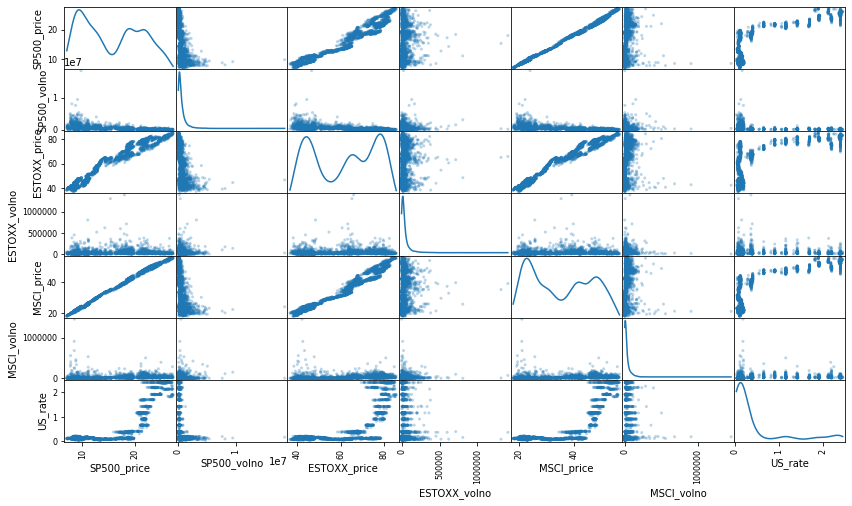

In [4]:
%matplotlib inline
pd.plotting.scatter_matrix(financialdfdata, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
financialdfdata.corr()

C:\software\anaconda3\envs\deeprlagent\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


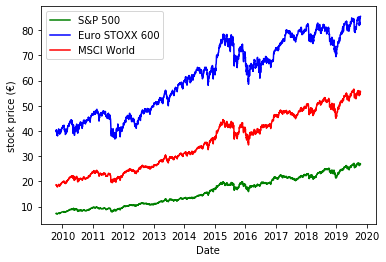

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(dfdata['date'], dfdata['SP500_price'] , color='green', label='S&P 500')
plt.plot(dfdata['date'], dfdata['ESTOXX_price'] , color='blue', label='Euro STOXX 600')
plt.plot(dfdata['date'], dfdata['MSCI_price'] , color='red', label='MSCI World')

#plt.plot(eps, rews2, color='black')

plt.xlabel('Date')
plt.ylabel('stock price (€)')
plt.legend()
plt.draw()
plt.show()

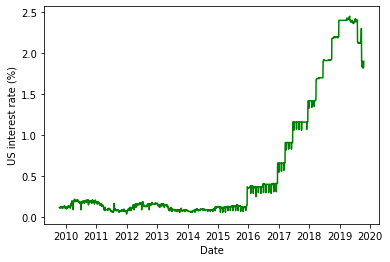

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(dfdata['date'], dfdata['US_rate'] , color='green')

plt.xlabel('Date')
plt.ylabel('US interest rate (%)')
plt.draw()
plt.show()

## Setting up the environment
The following cell splits the data in a training and test set and instantiates the market and task objects. The market object creates an interface to the stock prices and interest rates (i.e. market data).

In [7]:
%load_ext autoreload
%autoreload 2

# create test /validation data
dfdata_norecords = int(round(len(dfdata.index)*0.75))
dfdata_train = dfdata.iloc[0:dfdata_norecords,:]
dfdata_test = dfdata.iloc[dfdata_norecords:,:]

#create markets
market_train = Market(dfdata_train)
market_test = Market(dfdata_test)

# create tasks
monthly_allocation =  1000.0  #monthly upper spending limit
starting_budget =  120000.0  

task_train = Task(market_train, monthly_allocation, starting_budget, ['SP500'], 'SP500',-10.0, -5000.0)
task_test = Task(market_test, monthly_allocation, starting_budget, ['SP500'], 'SP500',-10.0, -5000.0)

labels = ['episode', 'time', 'price', 'action', 'portfolio', 'reward', 'total value']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The Task

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The market data comes from the `Market` class (from `market.py`).  
- Action repeats are not sensible for this use case, so their code was removed from the original implementation. 
- We set the number of elements in the state vector (`state_size`).  For the sample task, we only work with the 6-dimensional pose information.  
- The environment will always have a 1-dimensional action space, with the floating point entry encoding the transaction volume (`action_size=1`). We also set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The task in this provided file is for the agent to maximize the profit during the trading period.  We specify that target position as a variable.

The `reset()` method resets the market status.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `transactions`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the simulation date is outside the time interval of available market data.

## Running the benchmark agent

The agent given in `agents/buyandholdagent.py` uses a fixed action that is executed at the beginning of every month. The agent does not learn and is only there as a benchmark for the more sophisticated `agents/deeprlagent.py`.

The following code runs the agent and produces a baseline for comparison.

In [9]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from agents.buyandholdagent import BAH_Agent
from task import Task
import numpy as np
import csv
from datetime import datetime
import copy
from market import Market

dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y_%H%M%S")

file_output = 'data_bah_'+timestampStr+'.csv'          # file name for saved results
done = False
rewards_bench = []  # to store the total reward per episode
monthly_action = {'SP500': monthly_allocation - 1.0} #monthly investment of 1000€ in SP500
maxresults_bench = {x : [] for x in labels}  # to store the transactions of the best episode
maxreward = -10000
np.set_printoptions(precision=3, suppress=True)
agent = BAH_Agent(task_train, task_test, monthly_action) 

def report_evaluation(task:Task, reward:float):
    print('Time: {0:5d}'.format(task.market.currentdate))
    print('Portfolio: ' + str(task.portfolio))
    print('Total Value: {0:.2f}€'.format(task.get_total_value()))
    print('Total reward: {0:.2f}'.format(reward))

# training runs
with open(file_output, 'w', newline='\n', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    state = agent.reset_episode() # start a new episode, also resets task     
    results = {x : [] for x in labels}  # to store the trajectory of the best episode

    while True:
        action = agent.act(state) # delivers an action for the current state
        next_state, reward, done = task_train.step(action) # push the simulation further
        print(str(next_state))
          
        agent.step(action, reward, next_state, done)
            
        # store the details of the current episode
        to_write = [1]+[task_train.market.currentdate] + [task_train.market.get_value('SP500_price')] + [action[0]] \
        + [task_train.portfolio['SP500']] +[reward] + [task_train.get_total_value()]            
        
        writer.writerow(to_write)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])            
                        
        state = next_state               

        if done:
            rewards_bench.append((1, reward, task_train.market.currentdate, task_train.get_total_value())) #keep track of the total reward            
            if reward>=maxreward: #save the results of the best run so far
                maxreward=max(reward,maxreward)
                maxresults_bench = copy.deepcopy(results) #save the best run                
            break
sys.stdout.flush()

print('Best episode in the training results: ')
print('Time: {0:5d}'.format(maxresults_bench['time'][-1]))
print('Portfolio: {0:.2f}€'.format(maxresults_bench['portfolio'][-1]))
print('Total Value: {0:.2f}€'.format(maxresults_bench['total value'][-1]))
print('Total reward: {0:.2f}'.format(maxresults_bench['reward'][-1]))
print('\n')

# test runs
state = agent.reset_episode(True) # start a new episode in the test mode  
while True:
    action = agent.act(state) # delivers an action for the current state
    next_state, reward, done = task_test.step(action) # push the simulation further    
    state = next_state               
    if done:
        print('Test results: ')
        report_evaluation(task_test, reward)
        break
sys.stdout.flush()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[     0.        0.        0.        0.        0.        0.        0.
      0.        0.        7.25      0.        0.        0.        0.
      0.        0.        0.        0.        0.        0.12      0.
 120000.     1000.  ]
[     0.        0.        0.        0.        0.        0.        0.
      0.        7.25      7.33      0.        0.        0.        0.
      0.        0.        0.        0.        0.12      0.12      0.
 120000.     1000.  ]
[     0.        0.        0.        0.        0.        0.        0.
      7.25      7.33      7.3       0.        0.        0.        0.
      0.        0.        0.        0.12      0.12      0.12      0.
 120000.     1000.  ]
[     0.        0.        0.        0.        0.        0.        7.25
      7.33      7.3       7.31      0.        0.        0.        0.
      0.        0.        0.12      0.12      0.12      0.11      0.
 120000.     100

[     8.65       8.68       8.86       8.87       8.82       8.81
      8.79       8.76       8.79       8.9        0.09       0.17
      0.2        0.19       0.19       0.19       0.19       0.2
      0.2        0.22     501.342 116004.         1.   ]
[     8.68       8.86       8.87       8.82       8.81       8.79
      8.76       8.79       8.9        8.81       0.17       0.2
      0.19       0.19       0.19       0.19       0.2        0.2
      0.22       0.21     501.342 116004.         1.   ]
[     8.86       8.87       8.82       8.81       8.79       8.76
      8.79       8.9        8.81       8.82       0.2        0.19
      0.19       0.19       0.19       0.2        0.2        0.22
      0.21       0.2      501.342 116004.         1.   ]
[     8.87       8.82       8.81       8.79       8.76       8.79
      8.9        8.81       8.82       8.95       0.19       0.19
      0.19       0.19       0.2        0.2        0.22       0.21
      0.2        0.2      501.342 116004

[     8.37       8.29       8.28       8.33       8.32       8.3
      8.34       8.38       8.39       8.43       0.15       0.2
      0.2        0.2        0.19       0.18       0.18       0.18
      0.18       0.18     977.062 112008.         1.   ]
[     8.29       8.28       8.33       8.32       8.3        8.34
      8.38       8.39       8.43       8.34       0.2        0.2
      0.2        0.19       0.18       0.18       0.18       0.18
      0.18       0.19     977.062 112008.         1.   ]
[     8.28       8.33       8.32       8.3        8.34       8.38
      8.39       8.43       8.34       8.37       0.2        0.2
      0.19       0.18       0.18       0.18       0.18       0.18
      0.19       0.2      977.062 112008.         1.   ]
[     8.33       8.32       8.3        8.34       8.38       8.39
      8.43       8.34       8.37       8.42       0.2        0.19
      0.18       0.18       0.18       0.18       0.18       0.19
      0.2        0.19     977.062 112008.

[     9.47       9.44       9.54       9.57       9.52       9.4
      9.48       9.44       9.36       9.48       0.15       0.15
      0.15       0.16       0.15       0.16       0.15       0.15
      0.14       0.14    1413.978 108012.         1.   ]
[     9.44       9.54       9.57       9.52       9.4        9.48
      9.44       9.36       9.48       9.44       0.15       0.15
      0.16       0.15       0.16       0.15       0.15       0.14
      0.14       0.14    1413.978 108012.         1.   ]
[     9.54       9.57       9.52       9.4        9.48       9.44
      9.36       9.48       9.44       9.4        0.15       0.16
      0.15       0.16       0.15       0.15       0.14       0.14
      0.14       0.14    1413.978 108012.         1.   ]
[     9.57       9.52       9.4        9.48       9.44       9.36
      9.48       9.44       9.4        9.34       0.16       0.15
      0.16       0.15       0.15       0.14       0.14       0.14
      0.14       0.13    1413.978 1080

[     8.9        8.96       9.06       9.03       9.05       9.1
      9.17       9.08       9.17       9.21       0.08       0.08
      0.09       0.08       0.08       0.08       0.08       0.08
      0.08       0.08    2078.874 102018.         1.   ]
[     8.96       9.06       9.03       9.05       9.1        9.17
      9.08       9.17       9.21       9.2        0.08       0.09
      0.08       0.08       0.08       0.08       0.08       0.08
      0.08       0.09    2078.874 102018.         1.   ]
[     9.06       9.03       9.05       9.1        9.17       9.08
      9.17       9.21       9.2        9.27       0.09       0.08
      0.08       0.08       0.08       0.08       0.08       0.08
      0.09       0.08    2078.874 102018.         1.   ]
[     9.03       9.05       9.1        9.17       9.08       9.17
      9.21       9.2        9.27       9.11       0.08       0.08
      0.08       0.08       0.08       0.08       0.08       0.09
      0.08       0.08    2078.874 1020

 99021.        1.   ]
[   10.56     10.52     10.62     10.61     10.45     10.46     10.38
    10.46     10.48     10.54      0.13      0.16      0.15      0.15
     0.16      0.16      0.16      0.15      0.15      0.15   2384.332
 99021.        1.   ]
[   10.52     10.62     10.61     10.45     10.46     10.38     10.46
    10.48     10.54     10.45      0.16      0.15      0.15      0.16
     0.16      0.16      0.15      0.15      0.15      0.16   2384.332
 99021.        1.   ]
[   10.62     10.61     10.45     10.46     10.38     10.46     10.48
    10.54     10.45     10.48      0.15      0.15      0.16      0.16
     0.16      0.15      0.15      0.15      0.16      0.16   2384.332
 99021.        1.   ]
[   10.61     10.45     10.46     10.38     10.46     10.48     10.54
    10.45     10.48     10.47      0.15      0.16      0.16      0.16
     0.15      0.15      0.15      0.16      0.16      0.16   2384.332
 99021.        1.   ]
[   10.45     10.46     10.38     10.46     10

 96024.        1.   ]
[   11.11     11.21     11.19     11.22     11.19     11.19     11.12
    11.11     11.       11.05      0.16      0.16      0.15      0.15
     0.15      0.16      0.16      0.16      0.16      0.16   2659.022
 96024.        1.   ]
[   11.21     11.19     11.22     11.19     11.19     11.12     11.11
    11.       11.05     11.12      0.16      0.15      0.15      0.15
     0.16      0.16      0.16      0.16      0.16      0.16   2659.022
 96024.        1.   ]
[   11.19     11.22     11.19     11.19     11.12     11.11     11.
    11.05     11.12     11.1       0.15      0.15      0.15      0.16
     0.16      0.16      0.16      0.16      0.16      0.15   2659.022
 96024.        1.   ]
[   11.22     11.19     11.19     11.12     11.11     11.       11.05
    11.12     11.1      11.13      0.15      0.15      0.16      0.16
     0.16      0.16      0.16      0.16      0.15      0.15   2659.022
 96024.        1.   ]
[   11.19     11.19     11.12     11.11     11. 

 93027.        1.   ]
[   12.86     12.93     12.97     12.92     13.03     12.77     12.7
    12.78     12.94     12.64      0.11      0.1       0.1       0.09
     0.08      0.08      0.09      0.09      0.09      0.08   2926.622
 93027.        1.   ]
[   12.93     12.97     12.92     13.03     12.77     12.7      12.78
    12.94     12.64     12.64      0.1       0.1       0.09      0.08
     0.08      0.09      0.09      0.09      0.08      0.08   2926.622
 93027.        1.   ]
[   12.97     12.92     13.03     12.77     12.7      12.78     12.94
    12.64     12.64     12.71      0.1       0.09      0.08      0.08
     0.09      0.09      0.09      0.08      0.08      0.09   2926.622
 93027.        1.   ]
[   12.92     13.03     12.77     12.7      12.78     12.94     12.64
    12.64     12.71     12.36      0.09      0.08      0.08      0.09
     0.09      0.09      0.08      0.08      0.09      0.1    2926.622
 93027.        1.   ]
[   13.03     12.77     12.7      12.78     12.

 90030.        1.   ]
[   12.36     12.21     12.17     12.39     12.47     12.46     12.64
    12.7      12.59     12.68      0.08      0.08      0.09      0.09
     0.1       0.1       0.1       0.11      0.1       0.1    3164.977
 90030.        1.   ]
[   12.21     12.17     12.39     12.47     12.46     12.64     12.7
    12.59     12.68     12.71      0.08      0.09      0.09      0.1
     0.1       0.1       0.11      0.1       0.1       0.09   3164.977
 90030.        1.   ]
[   12.17     12.39     12.47     12.46     12.64     12.7      12.59
    12.68     12.71     12.67      0.09      0.09      0.1       0.1
     0.1       0.11      0.1       0.1       0.09      0.08   3164.977
 90030.        1.   ]
[   12.39     12.47     12.46     12.64     12.7      12.59     12.68
    12.71     12.67     12.63      0.09      0.1       0.1       0.1
     0.11      0.1       0.1       0.09      0.08      0.08   3164.977
 90030.        1.   ]
[   12.47     12.46     12.64     12.7      12.59 

 88032.        1.   ]
[   13.41     13.51     13.51     13.58     13.68     13.72     13.72
    13.46     13.36     13.39      0.08      0.08      0.06      0.08
     0.09      0.08      0.08      0.09      0.08      0.08   3315.447
 88032.        1.   ]
[   13.51     13.51     13.58     13.68     13.72     13.72     13.46
    13.36     13.39     13.33      0.08      0.06      0.08      0.09
     0.08      0.08      0.09      0.08      0.08      0.08   3315.447
 88032.        1.   ]
[   13.51     13.58     13.68     13.72     13.72     13.46     13.36
    13.39     13.33     13.14      0.06      0.08      0.09      0.08
     0.08      0.09      0.08      0.08      0.08      0.09   3315.447
 88032.        1.   ]
[   13.58     13.68     13.72     13.72     13.46     13.36     13.39
    13.33     13.14     13.23      0.08      0.09      0.08      0.08
     0.09      0.08      0.08      0.08      0.09      0.09   3315.447
 88032.        1.   ]
[   13.68     13.72     13.72     13.46     13

 83037.        1.   ]
[   16.51     16.11     15.9      16.08     15.97     16.53     16.85
    16.85     17.05     17.12      0.12      0.12      0.11      0.12
     0.13      0.13      0.13      0.13      0.13      0.13   3645.859
 83037.        1.   ]
[   16.11     15.9      16.08     15.97     16.53     16.85     16.85
    17.05     17.12     17.11      0.12      0.11      0.12      0.13
     0.13      0.13      0.13      0.13      0.13      0.13   3645.859
 83037.        1.   ]
[   15.9      16.08     15.97     16.53     16.85     16.85     17.05
    17.12     17.11     17.04      0.11      0.12      0.13      0.13
     0.13      0.13      0.13      0.13      0.13      0.12   3645.859
 83037.        1.   ]
[   16.08     15.97     16.53     16.85     16.85     17.05     17.12
    17.11     17.04     16.95      0.12      0.13      0.13      0.13
     0.13      0.13      0.13      0.13      0.12      0.12   3645.859
 83037.        1.   ]
[   15.97     16.53     16.85     16.85     17

 81039.        1.   ]
[   18.76     18.52     18.39     18.54     18.69     18.53     18.43
    18.53     18.57     18.52      0.13      0.13      0.13      0.13
     0.13      0.13      0.13      0.14      0.14      0.14   3750.277
 81039.        1.   ]
[   18.52     18.39     18.54     18.69     18.53     18.43     18.53
    18.57     18.52     18.61      0.13      0.13      0.13      0.13
     0.13      0.13      0.14      0.14      0.14      0.13   3750.277
 81039.        1.   ]
[   18.39     18.54     18.69     18.53     18.43     18.53     18.57
    18.52     18.61     18.62      0.13      0.13      0.13      0.13
     0.13      0.14      0.14      0.14      0.13      0.13   3750.277
 81039.        1.   ]
[   18.54     18.69     18.53     18.43     18.53     18.57     18.52
    18.61     18.62     18.88      0.13      0.13      0.13      0.13
     0.14      0.14      0.14      0.13      0.13      0.13   3750.277
 81039.        1.   ]
[   18.69     18.53     18.43     18.53     18

 77043.        1.   ]
[   17.99     18.61     18.62     18.87     18.55     18.26     18.39
    18.82     18.54     18.94      0.15      0.15      0.15      0.37
     0.37      0.36      0.36      0.36      0.36      0.36   3971.759
 77043.        1.   ]
[   18.61     18.62     18.87     18.55     18.26     18.39     18.82
    18.54     18.94     18.9       0.15      0.15      0.37      0.37
     0.36      0.36      0.36      0.36      0.36      0.35   3971.759
 77043.        1.   ]
[   18.62     18.87     18.55     18.26     18.39     18.82     18.54
    18.94     18.9      18.41      0.15      0.37      0.37      0.36
     0.36      0.36      0.36      0.36      0.35      0.36   3971.759
 77043.        1.   ]
[   18.87     18.55     18.26     18.39     18.82     18.54     18.94
    18.9      18.41     18.7       0.37      0.37      0.36      0.36
     0.36      0.36      0.36      0.35      0.36      0.36   3971.759
 77043.        1.   ]
[   18.55     18.26     18.39     18.82     18

 74046.        1.   ]
[   18.39     18.39     18.46     17.86     17.94     17.79     17.76
    17.96     17.84     17.96      0.37      0.37      0.37      0.3
     0.37      0.37      0.37      0.37      0.37      0.37   4138.831
 74046.        1.   ]
[   18.39     18.46     17.86     17.94     17.79     17.76     17.96
    17.84     17.96     18.17      0.37      0.37      0.3       0.37
     0.37      0.37      0.37      0.37      0.37      0.37   4138.831
 74046.        1.   ]
[   18.46     17.86     17.94     17.79     17.76     17.96     17.84
    17.96     18.17     18.1       0.37      0.3       0.37      0.37
     0.37      0.37      0.37      0.37      0.37      0.37   4138.831
 74046.        1.   ]
[   17.86     17.94     17.79     17.76     17.96     17.84     17.96
    18.17     18.1      18.01      0.3       0.37      0.37      0.37
     0.37      0.37      0.37      0.37      0.37      0.37   4138.831
 74046.        1.   ]
[   17.94     17.79     17.76     17.96     17.

 70050.        1.   ]
[   19.18     19.2      19.27     19.18     19.19     19.19     19.34
    19.26     19.34     19.16      0.4       0.29      0.4       0.4
     0.4       0.4       0.4       0.41      0.41      0.41   4348.839
 70050.        1.   ]
[   19.2      19.27     19.18     19.19     19.19     19.34     19.26
    19.34     19.16     19.36      0.29      0.4       0.4       0.4
     0.4       0.4       0.41      0.41      0.41      0.41   4348.839
 70050.        1.   ]
[   19.27     19.18     19.19     19.19     19.34     19.26     19.34
    19.16     19.36     19.28      0.4       0.4       0.4       0.4
     0.4       0.41      0.41      0.41      0.41      0.41   4348.839
 70050.        1.   ]
[   19.18     19.19     19.19     19.34     19.26     19.34     19.16
    19.36     19.28     19.39      0.4       0.4       0.4       0.4
     0.41      0.41      0.41      0.41      0.41      0.41   4348.839
 70050.        1.   ]
[   19.19     19.19     19.34     19.26     19.34 

Best episode in the training results: 
Time:  1893
Portfolio: 4541.35€
Total Value: 165736.63€
Total reward: 0.98


Test results: 
Time:   631
Portfolio: {'SP500': 722.8030713947467}
Total Value: 122496.54€
Total reward: 0.13


## Running the deep reinforcement agent

The agent given in `agents/deeprlagent.py` is executed and the results are evaluated.

In [66]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from agents.deeprlagent import DeepRL_Agent
from task import Task
import numpy as np
import csv
from datetime import datetime
import copy
from market import Market

dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y_%H%M%S")

file_output = 'data_deeprl_'+timestampStr+'.csv'          # file name for saved results
done = False
rewards_dl = []  # to store the total reward per episode
maxresults_dl = {x : [] for x in labels}  # to store the transactions of the best episode
num_episodes = 3
maxreward = -10000

agent = DeepRL_Agent(task_train, task_test) 

#################################
# training runs
#################################
with open(file_output, 'w', newline='\n', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode, also resets task     
        results = {x : [] for x in labels}  # to store the trajectory of the best episode

        while True:
            action = agent.act(state) # delivers an action for the current state
            next_state, reward, done = task_train.step(action) # push the simulation further
            
            agent.step(action, reward, next_state, done)
            
            # store the details of the current episode
            to_write = [i_episode]+[task_train.market.currentdate] + [task_train.market.get_value('SP500_price')]\
            + [action[0]] + [task_train.portfolio['SP500']] +[reward] + [task_train.get_total_value()]            
            writer.writerow(to_write)
            for ii in range(len(labels)):
                results[labels[ii]].append(to_write[ii])            
                        
            state = next_state               

            if done:
                rewards_dl.append((i_episode, reward, task_train.market.currentdate, task_train.get_total_value())) 
                if reward>=maxreward: #save the results of the best run so far
                    maxreward=max(reward,maxreward)
                    maxresults_dl = copy.deepcopy(results) #save the best run
                break
    sys.stdout.flush()
    
print('Best episode in the training results: ')
print('Time: {0:5d}'.format(maxresults_bench['time'][-1]))
print('Portfolio: {0:.2f}€'.format(maxresults_dl['portfolio'][-1]))
print('Total Value: {0:.2f}€'.format(maxresults_dl['total value'][-1]))
print('Total reward: {0:.2f}'.format(maxresults_dl['reward'][-1]))
print('\n')

##########################
# test run
##########################
def report_evaluation(task:Task, reward:float):
    print('Time: {0:5d}'.format(task.market.currentdate))
    print('Portfolio: ' + str(task.portfolio))
    print('Total Value: {0:.2f}€'.format(task.get_total_value()))
    print('Total reward: {0:.2f}'.format(reward))
    
file_output = 'data_deeprl_test_'+timestampStr+'.csv'          # file name for saved results
done = False
state = agent.reset_episode(True) # start a new episode in the test mode  

# training runs
with open(file_output, 'w', newline='\n', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)    
    while True:
        action = agent.act(state, True) # delivers an action for the current state
        next_state, reward, done = task_test.step(action) # push the simulation further        
        
        # store the details of the current episode
        to_write = [i_episode]+[task_test.market.currentdate] + [task_test.market.get_value('SP500_price')]\
            + [action[0]] + [task_test.portfolio['SP500']] +[reward] + [task_test.get_total_value()]            
        writer.writerow(to_write)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])            
                        
        state = next_state               

        if done:
            print('Test results: ')
            report_evaluation(task_test, reward)
            break
        sys.stdout.flush()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Best episode in the training results: 
Time:  1893
Portfolio: 3644.85€
Total Value: 157381.77€
Total reward: 0.93


Test results: 
Time:   631
Portfolio: {'SP500': 509.7213592529297}
Total Value: 122370.63€
Total reward: -0.13


## Plot the Rewards
### Learning progress (rewards)
The following graph shows the total rewards per episode as a graph. The red line is the benchmark and the black line shows the learning progress of the deeprl agent.

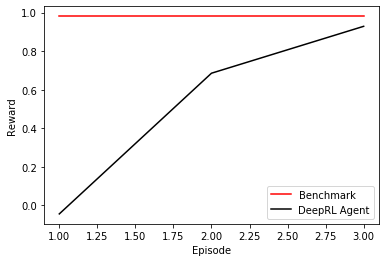

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

eps2, rews2, dur2, totval2 = np.array(rewards_dl).T
rews=np.full_like(rews2,rewards_bench[0][1])

plt.plot(eps2, rews, color='red', label='Benchmark')
plt.plot(eps2, rews2, color='black', label='DeepRL Agent')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.draw()
plt.show()

### Benchmark agent: Transactions over the best training period

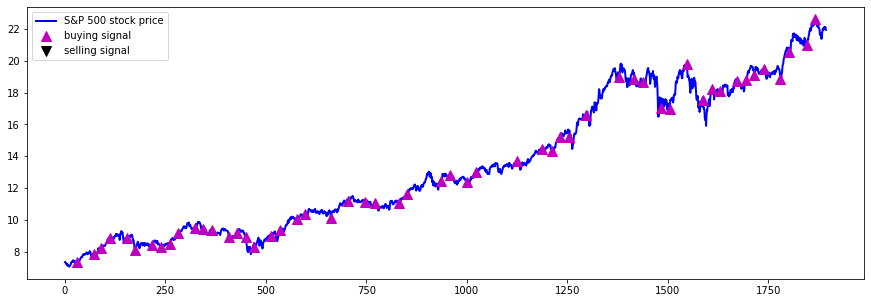

In [71]:
dfmaxresults = pd.DataFrame.from_dict(maxresults_bench)

selling_sign = []
buying_sign = []
for indx,rowelem in dfmaxresults.iterrows():
    if rowelem['action']<0.0:
        selling_sign.append(int(rowelem['time'])-1)    
    if rowelem['action']>0.0:    
        buying_sign.append(int(rowelem['time'])-1)

fig = plt.figure(figsize = (15,5))
plt.plot(dfmaxresults['time'], dfmaxresults['price'], color='b', lw=2., label='S&P 500 stock price')
plt.plot(dfmaxresults['time'], dfmaxresults['price'], '^', markersize=10, color='m', label = 'buying signal', markevery = buying_sign)
plt.plot(dfmaxresults['time'], dfmaxresults['price'], 'v', markersize=10, color='k', label = 'selling signal', markevery = selling_sign)
plt.legend()
plt.show()


### DeepRL agent: Transactions over the best training period

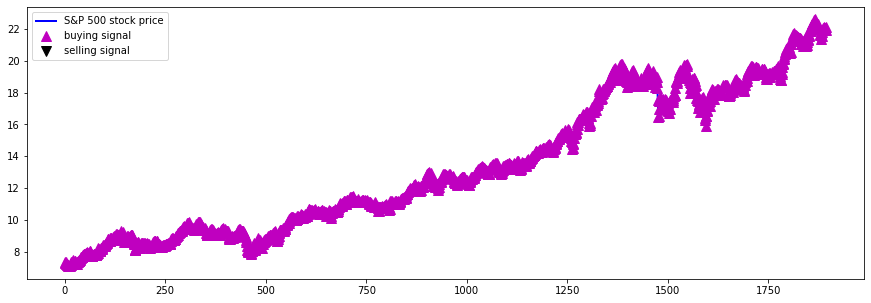

In [72]:
dfmaxresults = pd.DataFrame.from_dict(maxresults_dl)

selling_sign = []
buying_sign = []
for indx,rowelem in dfmaxresults.iterrows():
    if rowelem['action']<0.0:
        selling_sign.append(int(rowelem['time'])-1)    
    if rowelem['action']>0.0:    
        buying_sign.append(int(rowelem['time'])-1)

fig = plt.figure(figsize = (15,5))
plt.plot(dfmaxresults['time'], dfmaxresults['price'], color='b', lw=2., label='S&P 500 stock price')
plt.plot(dfmaxresults['time'], dfmaxresults['price'], '^', markersize=10, color='m', label = 'buying signal', markevery = buying_sign)
plt.plot(dfmaxresults['time'], dfmaxresults['price'], 'v', markersize=10, color='k', label = 'selling signal', markevery = selling_sign)
plt.legend()
plt.show()
